# Info
Name:  

    COSR_DARE

Purpose:  

    To Build the COSR DARE calculations
  
Input:

    arguments
  
Output:

    Figure and save files
  
Keywords:

    none
  
Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-10-04
    Modified: 

# Prepare python environment

In [13]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
from datetime import datetime
from scipy.interpolate import UnivariateSpline

In [29]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [31]:
name = 'COSR'
vv = 'v1'

In [5]:
fp =getpath('COSR')
fp_rtm = '/nobackup/sleblan2/rtm/'
fp_uvspec = '/u/sleblan2/libradtran/libRadtran-2.0-beta/bin/uvspec'
fp_rtmdat = '/nobackup/sleblan2/COSR/rtm/' #'/u/sleblan2/4STAR/rtm_dat/'

Return path named:  COSR /mnt/c/Users/sleblanc/Research/COSR/


## Setup command line interface

In [6]:
import argparse

In [7]:
long_description = """    Prepare or save the direct Aerosol radiative effect files for calculations. """

In [32]:
parser = argparse.ArgumentParser(description=long_description)
parser.add_argument('-doread','--doread',help='if set, will only read the output, not produce them',
                    action='store_true')
parser.add_argument('-d','--daystr',nargs='?',help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624')

_StoreAction(option_strings=['-d', '--daystr'], dest='daystr', nargs='?', const=None, default=None, type=None, choices=None, help='The day string (yyyymmdd) for the desired flight data. Defaults to 20180624', metavar=None)

In [9]:
in_ = vars(parser.parse_args())
do_read = in_.get('doread',False)
day = in_.get('daystr','20180624')

usage: ipykernel_launcher.py [-h] [-doread]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/sleblanc/.local/share/jupyter/runtime/kernel-675fec48-fd38-4288-acae-f5ab90ce1cf4.json


SystemExit: 2

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load files

## Load the in situ files

In [14]:
neph = sio.loadmat(fp+'20180624_nephclap.csv_20191004_152550.mat.mat')

In [15]:
neph.keys()

['__function_workspace__', 'None', '__version__', '__header__', '__globals__']

In [28]:
neph['None'][0][4]

IndexError: invalid index (4)

In [34]:
situ = pd.read_csv(fp+'{}_neph_clap.csv'.format(day))

In [36]:
situ

,DateTimeUTC,totScat_450nm,totScatCalc_500nm,totScat_550nm,totScat_700nm,scatFitSlope,scatFitIncpt,angScat,totAbs_467nm,totAbsCalc_500nm,totAbs_528nm,totAbs_652nm,absFitSlope,absFitIncpt,angAbs,extCalc500nm
0,2018-06-24 14:14:00,1.80,1.402245,1.17,0.52,-2.828733,17.917542,2.828733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-24 14:15:00,1.43,1.281489,1.28,0.59,-2.043880,12.949936,2.043880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-24 14:16:00,1.81,1.484451,1.24,0.79,-1.876155,12.054614,1.876155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-24 14:17:00,2.00,1.672541,1.47,0.82,-2.031338,13.138311,2.031338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-24 14:18:00,2.32,1.898734,1.55,1.10,-1.680126,11.082512,1.680126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-06-24 14:19:00,2.32,1.908862,1.64,0.92,-2.103533,13.719140,2.103533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-06-24 14:20:00,2.21,2.037622,2.06,1.09,-1.634308,10.868368,1.634308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-06-24 14:20:58,3.79,3.130448,3.22,0.71,-3.873120,25.211101,3.873120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-06-24 14:20:59,4.10,3.137733,2.52,1.21,-2.771368,18.366468,2.771368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-06-24 14:21:00,3.91,2.798897,2.09,0.92,-3.279057,21.407277,3.279057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
insitu = situ.to_dict('list')

In [46]:
insitu.keys()

['totScat_450nm',
 'totScat_700nm',
 'scatFitSlope',
 'totScat_550nm',
 'totAbs_528nm',
 'totAbs_467nm',
 'totAbsCalc_500nm',
 'totAbs_652nm',
 'totScatCalc_500nm',
 'DateTimeUTC',
 'angScat',
 'angAbs',
 'absFitSlope',
 'extCalc500nm',
 'absFitIncpt',
 'scatFitIncpt']

In [56]:
[insitu[k]=np.array(insitu[k]) for k in insitu.keys()]

SyntaxError: invalid syntax (<ipython-input-56-305fc7e8ca9c>, line 1)

In [47]:
insitu['ssa_500nm'] = np.array(insitu['totScatCalc_500nm'])/np.array(insitu['extCalc500nm'])

In [50]:
import Sp_parameters as Sp

<IPython.core.display.Javascript object>


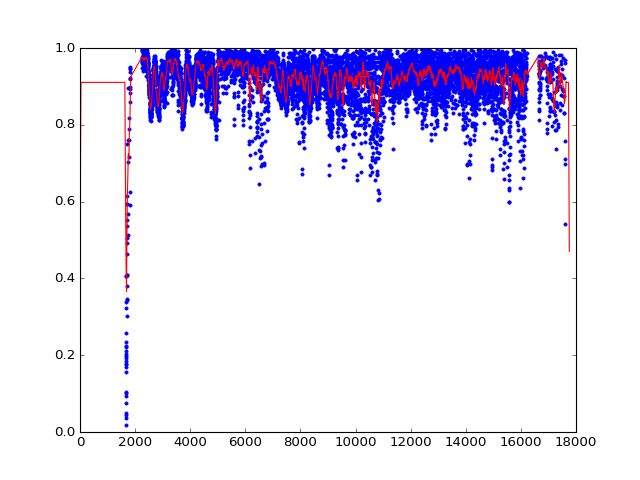

In [55]:
plt.figure()
plt.plot(insitu['ssa_500nm'],'.')
plt.plot(Sp.smooth(insitu['ssa_500nm'],60,old=True),'-r')

## Load the skyscan results

In [17]:
sky = sio.loadmat(fp+'4STAR_20180624_135_SKYP.created_20190329_003621.ppl_lv15.mat')

In [18]:
sky.keys()

['sky_radiances_pct_diff',
 'ext_fine',
 'flux_dn',
 'Sphericity_err',
 'Sphericity',
 'sky_radiances_angle',
 'sky_radiances_measured',
 'ssa_total',
 'radius',
 'flux_diffuse',
 'sfc_alb',
 'input_fname',
 'ssa_coarse',
 'sky_bias',
 'aaod',
 'fstem',
 'tod_fit',
 'output_fname',
 'g_coarse',
 'tod_meas',
 'input',
 'PF_coarse',
 'PF_total',
 'PF_fine',
 'aod',
 'g_fine',
 'refractive_index_real_r',
 'refractive_index_imaginary_r',
 'tod_meas_less_fit',
 'g_tot',
 'psd',
 'Wavelength',
 'PF_angle',
 '__version__',
 'ext_coarse',
 'ext_total',
 '__header__',
 '__globals__',
 'flux_up',
 'ssa_fine',
 'sky_radiances_fit',
 'sky_error']

# Run analysis and prepare variables
Do some of the calculations to the data here

# Plotting
Present some fo the early plots here